In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('Data for Cleaning & Modeling.csv')
train_df.head(2)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,11.89%,54734.0,80364.0,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,< 1 year,RENT,85000.0,VERIFIED - income,Aug-09,Due to a lack of personal finance education an...,debt_consolidation,Debt consolidation for on-time payer,941xx,CA,19.48,0.0,Feb-94,0.0,NaN,NaN,10.0,0.0,28854.0,52.10%,42.0,f
1,10.71%,55742.0,114426.0,"$7,000","$7,000",$673,36 months,B,B5,CNN,< 1 year,RENT,65000.0,not verified,May-08,Just want to pay off the last bit of credit ca...,credit_card,Credit Card payoff,112xx,NY,14.29,0.0,Oct-00,0.0,NaN,NaN,7.0,0.0,33623.0,76.70%,7.0,f


In [3]:
cols = ['interest_rate', 'id','borrower_id','loan_requested','loan_funded',
        'investor_funded_portion','no_of_payments','grade','subgrade','job_title',
        'years_employed', 'ownership_status', 'annual_income', 'income_verified_bool',
        'date_issued', 'reason_for_loan', 'category', 'loan_title', 'zip_code', 'state', 'debt_ratio', 'deliquence_incidences',
        'min_date_credit_line', 'creditors_inquiries', 'months_since_last_delinquency', 'months_since_last_public_record',
        'open_credit_lines', 'no_derogatory_public_records', 'total_credit_revolving_balance', 'revolving_line_utilization_rate',
        'total_credit_lines', 'initial_listing_status']

train_df.columns = cols

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 32 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   interest_rate                    338990 non-null  object 
 1   id                               399999 non-null  float64
 2   borrower_id                      399999 non-null  float64
 3   loan_requested                   399999 non-null  object 
 4   loan_funded                      399999 non-null  object 
 5   investor_funded_portion          399999 non-null  object 
 6   no_of_payments                   399999 non-null  object 
 7   grade                            338730 non-null  object 
 8   subgrade                         338730 non-null  object 
 9   job_title                        376014 non-null  object 
 10  years_employed                   382462 non-null  object 
 11  ownership_status                 338639 non-null  object 
 12  an

In [5]:
def missing_values(df):
    missing_ = df.isnull().sum()
    missing_perc = (missing_/df.shape[0]) * 100

    print(missing_perc.sort_values(ascending=False))

    return missing_, missing_perc

In [6]:
missing_, missing_perc = missing_values(train_df)
cols_to_drop = missing_perc[missing_perc>50].index

loan_df = train_df.drop(cols_to_drop, axis = 1)
loan_df = loan_df.drop(['id','borrower_id','loan_title'], axis = 1)
loan_df = loan_df[~loan_df['interest_rate'].isnull()]

months_since_last_public_record    87.21125
reason_for_loan                    69.11000
months_since_last_delinquency      54.70050
ownership_status                   15.34025
grade                              15.31750
subgrade                           15.31750
annual_income                      15.25700
interest_rate                      15.25250
job_title                           5.99650
years_employed                      4.38450
revolving_line_utilization_rate     0.06675
loan_title                          0.00475
debt_ratio                          0.00025
open_credit_lines                   0.00025
no_derogatory_public_records        0.00025
total_credit_revolving_balance      0.00025
total_credit_lines                  0.00025
creditors_inquiries                 0.00025
min_date_credit_line                0.00025
deliquence_incidences               0.00025
category                            0.00025
state                               0.00025
zip_code                        

In [7]:
loan_df['job_title'] = loan_df['job_title'].fillna('umemployed')
top_n = loan_df['job_title'].value_counts().index[:25]
loan_df['job_title'] = loan_df['job_title'].apply(lambda x: x if x in top_n else 'others')

In [8]:
#replacing null income with years_employed group median
loan_df['years_employed'] = loan_df['years_employed'].fillna('0 year')
loan_df['years_employed'] = loan_df['years_employed'].str.replace('< 1 year','0 year')

income_dictionary = dict(loan_df.groupby(['years_employed'])['annual_income'].median())

for i in loan_df['years_employed'].unique():
    loan_df.loc[(loan_df['annual_income'].isnull()) & (loan_df['years_employed'] == i),'annual_income'] = income_dictionary[i]

In [9]:
#Data Cleaning
loan_df['ownership_status'] = loan_df['ownership_status'].fillna('NONE')
loan_df['income_verified_bool'] = loan_df['income_verified_bool'].str.replace('VERIFIED - income source','VERIFIED - income')
loan_df['revolving_line_utilization_rate'] = loan_df['revolving_line_utilization_rate'].fillna('0%')
loan_df['grade'] = loan_df['grade'].fillna(loan_df['grade'].mode().values[0])
loan_df['subgrade'] = loan_df['subgrade'].fillna(loan_df['subgrade'].mode().values[0])
loan_df['zip_code'] = loan_df['zip_code'].fillna(loan_df['zip_code'].mode().values[0])

In [10]:
for i in ['interest_rate', 'revolving_line_utilization_rate']:
    loan_df[i] = loan_df[i].str.replace('%','').astype(float)

for i in ['loan_requested', 'loan_funded', 'investor_funded_portion','years_employed']:
    loan_df[i] = loan_df[i].str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(float)

In [11]:
loan_df = loan_df.dropna()
missing_, missing_perc = missing_values(loan_df)
missing_perc[missing_perc>0].sort_values(ascending=False)

interest_rate                      0.0
loan_requested                     0.0
total_credit_lines                 0.0
revolving_line_utilization_rate    0.0
total_credit_revolving_balance     0.0
no_derogatory_public_records       0.0
open_credit_lines                  0.0
creditors_inquiries                0.0
min_date_credit_line               0.0
deliquence_incidences              0.0
debt_ratio                         0.0
state                              0.0
zip_code                           0.0
category                           0.0
date_issued                        0.0
income_verified_bool               0.0
annual_income                      0.0
ownership_status                   0.0
years_employed                     0.0
job_title                          0.0
subgrade                           0.0
grade                              0.0
no_of_payments                     0.0
investor_funded_portion            0.0
loan_funded                        0.0
initial_listing_status   

Series([], dtype: float64)

In [12]:
#loan_df['date_issued'] = pd.to_datetime(loan_df['date_issued'], format = '%b-%y')
#loan_df['min_date_credit_line'] = pd.to_datetime(loan_df['min_date_credit_line'], format = '%b-%y')
#loan_df['months_since_first_credit_line'] = round((loan_df['date_issued'] - loan_df['min_date_credit_line']).dt.days/30)
loan_df['perc_open_credit_lines'] = loan_df['open_credit_lines']/loan_df['total_credit_lines']
loan_df['loan_perc_income'] = loan_df['loan_funded']/loan_df['annual_income']
loan_df['perc_loan_funded'] = loan_df['loan_funded']/loan_df['loan_requested']
loan_df['interest_rate'] = loan_df['interest_rate']/100
loan_df['revolving_line_utilization_rate'] = loan_df['revolving_line_utilization_rate']/100

In [13]:
loan_df_new = loan_df.drop(['date_issued','min_date_credit_line',
                            'state','investor_funded_portion','job_title','zip_code'
                            ], axis = 1).reset_index(drop = True)

loan_df_new.head(2)

,interest_rate,loan_requested,loan_funded,no_of_payments,grade,subgrade,years_employed,ownership_status,annual_income,income_verified_bool,category,debt_ratio,deliquence_incidences,creditors_inquiries,open_credit_lines,no_derogatory_public_records,total_credit_revolving_balance,revolving_line_utilization_rate,total_credit_lines,initial_listing_status,perc_open_credit_lines,loan_perc_income,perc_loan_funded
0,0.1189,25000.0,25000.0,36 months,B,B4,0.0,RENT,85000.0,VERIFIED - income,debt_consolidation,19.48,0.0,0.0,10.0,0.0,28854.0,0.521,42.0,f,0.238095,0.294118,1.0
1,0.1071,7000.0,7000.0,36 months,B,B5,0.0,RENT,65000.0,not verified,credit_card,14.29,0.0,0.0,7.0,0.0,33623.0,0.767,7.0,f,1.000000,0.107692,1.0


In [14]:
loan_df_new = pd.concat([loan_df_new, pd.get_dummies(loan_df_new['ownership_status'])], axis = 1)
loan_df_new = pd.concat([loan_df_new, pd.get_dummies(loan_df_new['category'])], axis = 1)

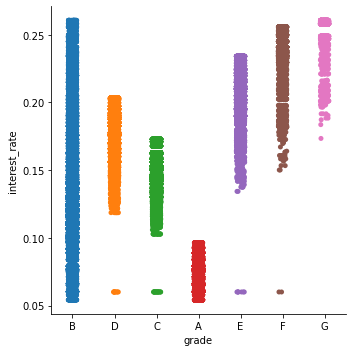

In [15]:
import seaborn as sns
sns.catplot(x = "grade", y = "interest_rate", data = loan_df_new)

In [16]:
X = loan_df_new.drop('interest_rate', axis = 1)
y = loan_df_new['interest_rate']

X.shape, y.shape

((338989, 42), (338989,))

In [19]:
holdout = pd.read_csv('Holdout for Testing.csv')

holdout_df = holdout.copy()

holdout_df.columns = cols
holdout_df.head(2)

,interest_rate,id,borrower_id,loan_requested,loan_funded,investor_funded_portion,no_of_payments,grade,subgrade,job_title,years_employed,ownership_status,annual_income,income_verified_bool,date_issued,reason_for_loan,category,loan_title,zip_code,state,debt_ratio,deliquence_incidences,min_date_credit_line,creditors_inquiries,months_since_last_delinquency,months_since_last_public_record,open_credit_lines,no_derogatory_public_records,total_credit_revolving_balance,revolving_line_utilization_rate,total_credit_lines,initial_listing_status
0,NaN,44409194,47416907,"$6,000","$6,000","$6,000",36 months,C,C5,Electrician,10+ years,MORTGAGE,68000.0,VERIFIED - income,15-Mar,NaN,debt_consolidation,Debt consolidation,430xx,OH,28.31,0,2-Nov,1,26.0,NaN,18,0,19861,64.50%,33,f
1,NaN,44017917,47034722,"$24,000","$24,000","$24,000",36 months,A,A1,Executive Assistant,8 years,RENT,110480.0,VERIFIED - income,15-Mar,NaN,debt_consolidation,Debt consolidation,945xx,CA,16.03,0,Dec-68,1,NaN,NaN,12,0,17001,26.20%,36,w


In [20]:
holdout_df = holdout_df.drop(cols_to_drop, axis = 1)
holdout_df = holdout_df.drop(['id','borrower_id','loan_title'], axis = 1)
holdout_df['job_title'] = holdout_df['job_title'].fillna('umemployed')
holdout_df['job_title'] = holdout_df['job_title'].apply(lambda x: x if x in top_n else 'others')

holdout_df['years_employed'] = holdout_df['years_employed'].fillna('0 year')
holdout_df['years_employed'] = holdout_df['years_employed'].str.replace('< 1 year','0 year')

for i in holdout_df['years_employed'].unique():
    holdout_df.loc[(holdout_df['annual_income'].isnull()) & (holdout_df['years_employed'] == i),'annual_income'] = income_dictionary[i]

holdout_df['ownership_status'] = holdout_df['ownership_status'].fillna('NONE')
holdout_df['income_verified_bool'] = holdout_df['income_verified_bool'].str.replace('VERIFIED - income source','VERIFIED - income')
holdout_df['revolving_line_utilization_rate'] = holdout_df['revolving_line_utilization_rate'].fillna('0%')
holdout_df['grade'] = holdout_df['grade'].fillna(loan_df['grade'].mode().values[0])
holdout_df['subgrade'] = holdout_df['subgrade'].fillna(loan_df['subgrade'].mode().values[0])
holdout_df['zip_code'] = holdout_df['zip_code'].fillna(loan_df['zip_code'].mode().values[0])

holdout_df['revolving_line_utilization_rate'] = holdout_df['revolving_line_utilization_rate'].str.replace('%','').astype(float)

for i in ['loan_requested', 'loan_funded', 'investor_funded_portion','years_employed']:
    holdout_df[i] = holdout_df[i].str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(float)

holdout_df['perc_open_credit_lines'] = holdout_df['open_credit_lines']/holdout_df['total_credit_lines']
holdout_df['loan_perc_income'] = holdout_df['loan_funded']/holdout_df['annual_income']
holdout_df['perc_loan_funded'] = holdout_df['loan_funded']/holdout_df['loan_requested']
holdout_df['revolving_line_utilization_rate'] = holdout_df['revolving_line_utilization_rate']/100

holdout_df = holdout_df.drop(['date_issued','min_date_credit_line',
                              'state','investor_funded_portion','job_title','zip_code'
                              ], axis = 1)

holdout_df = holdout_df.drop('interest_rate', axis = 1)

holdout_df = pd.concat([holdout_df, pd.get_dummies(holdout_df['ownership_status'])], axis = 1)
holdout_df = pd.concat([holdout_df, pd.get_dummies(holdout_df['category'])], axis = 1)

holdout_df[list(set(X.columns) - set(holdout_df.columns))] = 0
holdout_df.shape


(80000, 42)

In [21]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = loan_df_new.select_dtypes('object').columns
for categorical_column in categorical_columns: 
    le = LabelEncoder()
    to_fit = X[categorical_column].append(holdout_df[categorical_column])
    le.fit(to_fit)
    X[categorical_column] = le.transform(X[categorical_column])
    holdout_df[categorical_column] = le.transform(holdout_df[categorical_column])


In [22]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [25]:
def run_model(model, name):
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**(1/2)
    rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
    r2_test = r2_score(y_test, y_pred)
    r2_train = model.score(X_train, y_train)
    print(f"Training RMSE: {rmse_train}")
    print(f"Testing RMSE: {rmse_test}")
    print(f"Testing R2: {r2_test}")
    print(f"Training R2: {r2_train}")

    plt.figure(figsize=(15,10))

    importances_rf = pd.Series(model.feature_importances_,index = X.columns)
    sorted_importances_rf = importances_rf.sort_values()
    sorted_importances_rf.plot(kind='barh', color='blue')
    plt.title(name)
    plt.show()

    return rmse_train, rmse_test, r2_test, r2_train

Fitting XGBoost...
Training RMSE: 0.013804990323290418
Testing RMSE: 0.014403406615776996
Testing R2: 0.8925867560188794
Training R2: 0.900374234184492


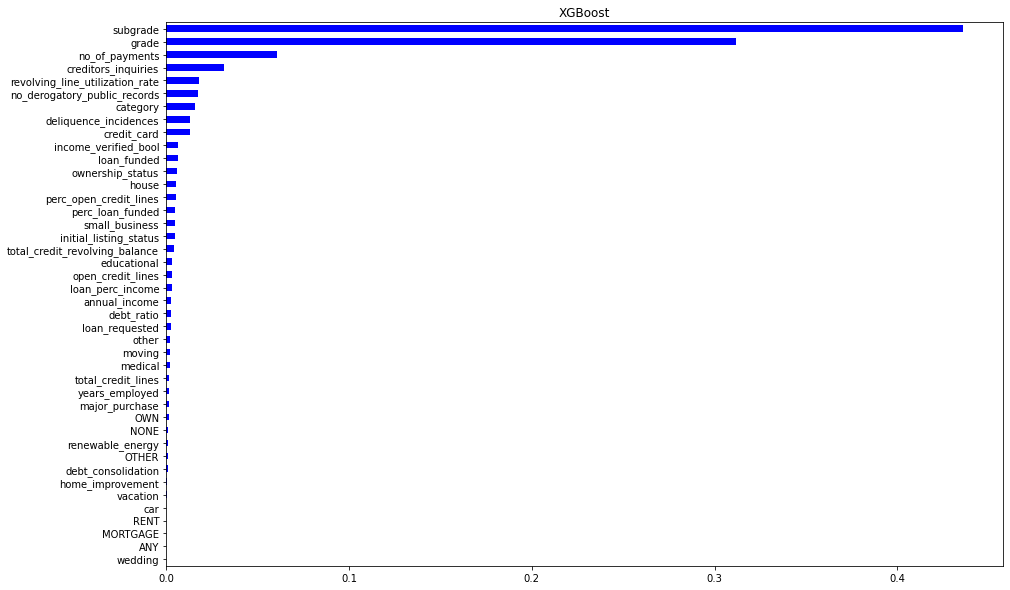

Fitting GradientBoosting...
Training RMSE: 0.016063949486531056
Testing RMSE: 0.01599254145954421
Testing R2: 0.8675773236621558
Training R2: 0.8651024322278226


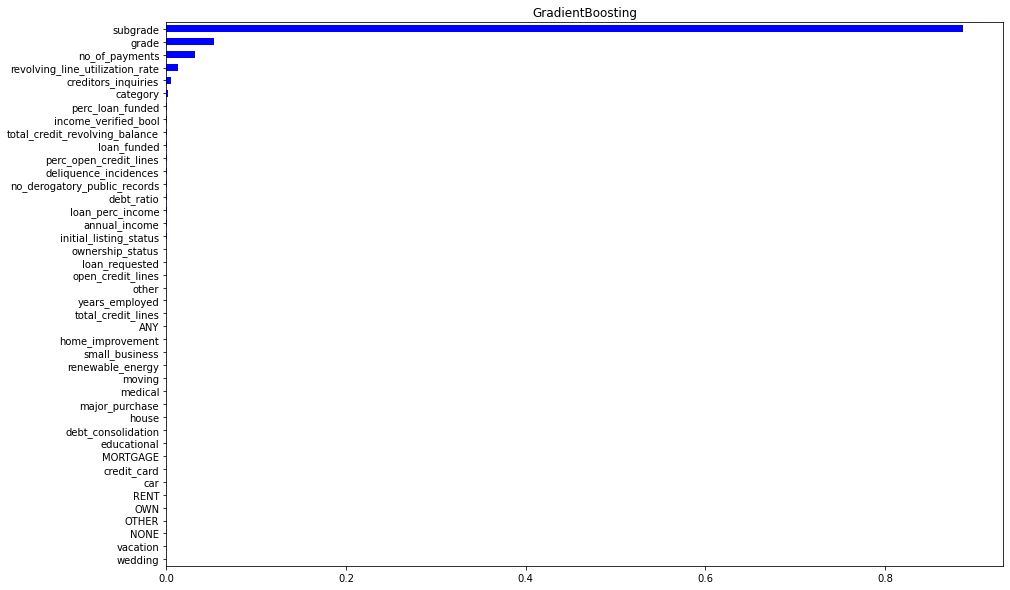

Fitting AdaBoost...
Training RMSE: 0.02197495477078562
Testing RMSE: 0.022014103527906826
Testing R2: 0.7490833968530031
Training R2: 0.7475615880420885


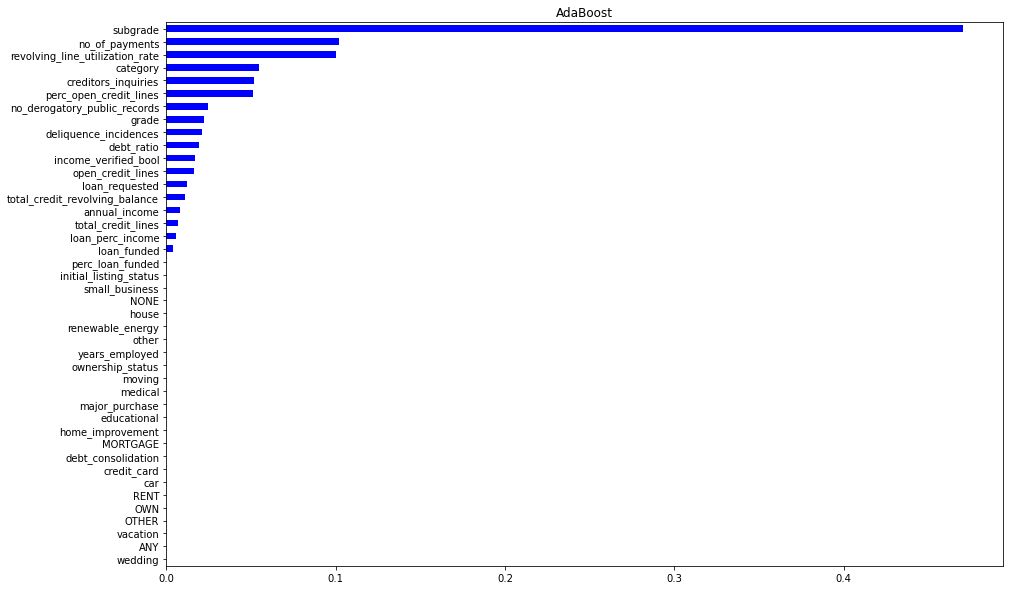

Fitting RandomForest...
Training RMSE: 0.005554526976229905
Testing RMSE: 0.014772808200567058
Testing R2: 0.8870064875612474
Training R2: 0.9838715133033694


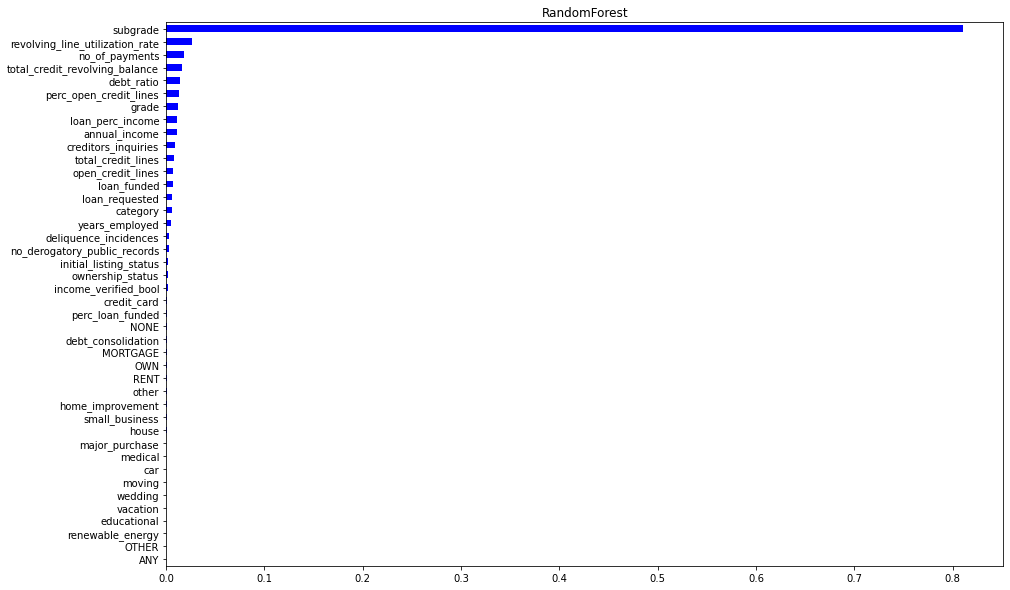

In [26]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor()
gbr = GradientBoostingRegressor()
abr = AdaBoostRegressor()
rf = RandomForestRegressor()

rmse_train_xgb, rmse_test_xgb, r2_test_xgb, r2_train_xgb = run_model(xgb, 'XGBoost')
rmse_train_gbr, rmse_test_gbr, r2_test_gbr, r2_train_gbr = run_model(gbr, 'GradientBoosting')
rmse_train_abr, rmse_test_abr, r2_test_abr, r2_train_abr = run_model(abr, 'AdaBoost')
rmse_train_rf, rmse_test_rf, r2_test_rf, r2_train_rf = run_model(rf, 'RandomForest')

In [27]:
models = pd.DataFrame({
    'Model': ['XGBoost', 'RandomForest', 'GradientBoosting', 'AdaBoost'],
    
    'RMSE Train': [rmse_train_xgb, rmse_train_rf, rmse_train_gbr, rmse_train_abr],
    'RMSE Test': [rmse_test_xgb, rmse_test_rf, rmse_test_gbr, rmse_test_abr],
    'R2 Train': [r2_train_xgb, r2_train_rf, r2_train_gbr, r2_train_abr],
    'R2 Test': [r2_test_xgb, r2_test_rf, r2_test_gbr, r2_test_abr]
    })

models.sort_values(by='RMSE Test', ascending=True)

,Model,RMSE Train,RMSE Test,R2 Train,R2 Test
0,XGBoost,0.013805,0.014403,0.900374,0.892587
1,RandomForest,0.005555,0.014773,0.983872,0.887006
2,GradientBoosting,0.016064,0.015993,0.865102,0.867577
3,AdaBoost,0.021975,0.022014,0.747562,0.749083


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

# define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

# define the cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# create an XGBoost Regressor object
xgb = XGBRegressor()

# perform the grid search
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X, y)

# print the best hyperparameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best mean squared error: {-grid_search.best_score_}")

In [28]:
import pickle
# save
with open('xgb.pkl','wb') as f:
    pickle.dump(grid_search,f)

In [29]:
# load
with open('xgb.pkl', 'rb') as f:
    grid_search = pickle.load(f)

holdout_df = holdout_df[X.columns]
y_pred = grid_search.predict(holdout_df)

In [30]:
holdout['X1'] = y_pred * 100
submission = holdout[['X1','X2']]
submission.to_csv('Results from Naman.csv', index = False)